In [1]:
import os

import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt
import lightning as L

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from data_module.data_module import FFTDataModule
from model.classifier_model import Classifier1D

import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TEST = False

random_seed = 42
lin_gyr_dataset_path = "dataset/processed_concat_data"


In [3]:
from lightning.pytorch.utilities.model_summary import ModelSummary

net = Classifier1D(
    cnn_channel_param = [
        (6, 32, 8, 0, 3),
        (32, 64, 8, 0, 3)
    ],
    linear_channel_param = [
        256, 128
    ],
    out_class_num=5,).to("cpu")

model_summary = ModelSummary(net, max_depth=6)
print(model_summary)

   | Name     | Type        | Params | In sizes     | Out sizes   
------------------------------------------------------------------------
0  | cnn      | Sequential  | 18.0 K | [10, 6, 257] | [10, 64, 26]
1  | cnn.0    | Conv1d      | 1.6 K  | [10, 6, 257] | [10, 32, 84]
2  | cnn.1    | ReLU        | 0      | [10, 32, 84] | [10, 32, 84]
3  | cnn.2    | Dropout     | 0      | [10, 32, 84] | [10, 32, 84]
4  | cnn.3    | Conv1d      | 16.4 K | [10, 32, 84] | [10, 64, 26]
5  | cnn.4    | ReLU        | 0      | [10, 64, 26] | [10, 64, 26]
6  | cnn.5    | Dropout     | 0      | [10, 64, 26] | [10, 64, 26]
7  | linear   | Sequential  | 460 K  | [10, 1664]   | [10, 8]     
8  | linear.0 | Linear      | 426 K  | [10, 1664]   | [10, 256]   
9  | linear.1 | BatchNorm1d | 512    | [10, 256]    | [10, 256]   
10 | linear.2 | ReLU        | 0      | [10, 256]    | [10, 256]   
11 | linear.3 | Linear      | 32.9 K | [10, 256]    | [10, 128]   
12 | linear.4 | BatchNorm1d | 256    | [10, 128]    | [1

In [9]:
n_epochs = 20000
patience = n_epochs//100

optimizer_param_dict = {
    "Adam": (optim.Adam, {
        "lr": 0.001,
    }),
    "SGD": (optim.SGD, {
        "lr": 0.001,
        "momentum": 0.5,
    }),
}
optimizer, optimizer_param = optimizer_param_dict["SGD"]
dataset_path = lin_gyr_dataset_path

log_save_dir = "lightning_logs"
log_save_name = "10_classify_5classes_10000data"

In [ ]:
print(" ----------------------start training---------------------------")
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger

tensorboard_logger = TensorBoardLogger(save_dir=log_save_dir, name=log_save_name,)
csv_logger = CSVLogger(save_dir=log_save_dir, name=log_save_name,)
checkpoint_callback = ModelCheckpoint(
    dirpath=None,
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    filename="sample_{epoch:02d}-{step:02d}-{val_loss:02f}"
)

trainer = L.Trainer(
    logger=[tensorboard_logger, csv_logger],
    callbacks=[EarlyStopping(monitor="val_loss", patience=patience), checkpoint_callback],
    max_epochs=n_epochs,
    check_val_every_n_epoch=10,
    accelerator="gpu", 
    devices=4, 
    strategy="ddp"
    )

net = Classifier1D(
    optimizer = optimizer,
    optimizer_param = optimizer_param, 
    cnn_channel_param = [
        (6, 32, 8, 0, 3),
        (32, 64, 8, 0, 3)
    ],
    linear_channel_param = [
        256, 128
    ],
    out_class_num = 5,
)

data_module = FFTDataModule(dataset_path=lin_gyr_dataset_path, batch_size=512)

trainer.fit(model=net, datamodule=data_module)
trainer.test(model=net, datamodule=data_module)

In [4]:
checkpoint_path = "/nfs/ksdata/tran/HAR_AE/lightning_logs/10_classify_5classes_10000data/version_2/checkpoints/sample_epoch=7879-step=157600-val_loss=0.109504.ckpt"

data_module = FFTDataModule.load_from_checkpoint(checkpoint_path)
net = Classifier1D.load_from_checkpoint(checkpoint_path)

trainer = L.Trainer()

trainer.test(model=net, datamodule=data_module)
output = trainer.predict(model=net, datamodule=data_module)
pred = torch.argmax(torch.concat(output), dim=1)
gt = list(map(lambda x: x[1], iter(data_module.predict_dataloader())))

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024-01-29 15:40:39.604598: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the followi

Testing DataLoader 0: 100%|███████████████████████████████████| 10/10 [00:01<00:00,  7.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9702197313308716
        test_loss           0.1047929972410202
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|███████████████████████████████| 10/10 [00:00<00:00, 145.50it/s]


Accuracy 0.9702197576504415
F1 0.9712063132812572
[[982   7   0   7   4]
 [ 25 969   0   4   2]
 [  1   4 864   0   0]
 [ 22   3   0 972   3]
 [ 61   0   0   2 937]]


[Text(0.5, 23.52222222222222, 'Predict'),
 Text(50.722222222222214, 0.5, 'Ground truth'),
 [Text(0.5, 0, 'still'),
  Text(1.5, 0, 'walking'),
  Text(2.5, 0, 'run'),
  Text(3.5, 0, 'bike'),
  Text(4.5, 0, 'bus')],
 [Text(0, 0.5, 'still'),
  Text(0, 1.5, 'walking'),
  Text(0, 2.5, 'run'),
  Text(0, 3.5, 'bike'),
  Text(0, 4.5, 'bus')]]

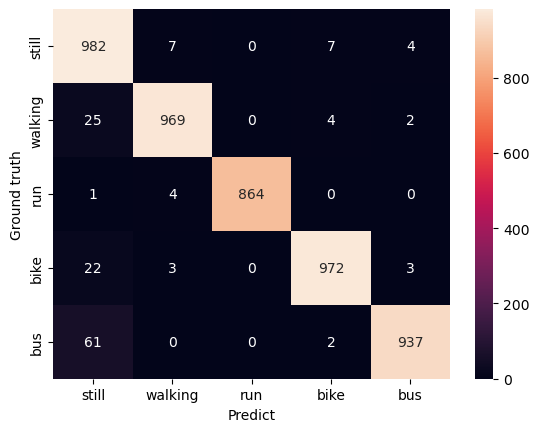

In [5]:
pred_ravel = np.concatenate(list(map(lambda x: x.numpy(), pred)))
gt_ravel = np.concatenate(list(map(lambda x: x.numpy(), gt)))

accuracy = accuracy_score(gt_ravel, pred_ravel)
print("Accuracy", accuracy)

f1 = f1=f1_score(gt_ravel, pred_ravel, average="macro")
print("F1", f1)

cf = confusion_matrix(gt_ravel, pred_ravel)

print(cf)
label_list = ["still", "walking", "run", "bike", "bus"]
s = sns.heatmap(cf, annot=True, fmt='g')
s.set(xlabel="Predict", ylabel="Ground truth", xticklabels=label_list, yticklabels=label_list)